## Import packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib import cm
import os
import csv
import warnings
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense

warnings.filterwarnings('ignore')

## Import individual ZLP spectra

Outputs: file1, file2, ... file13

<Figure size 432x288 with 0 Axes>

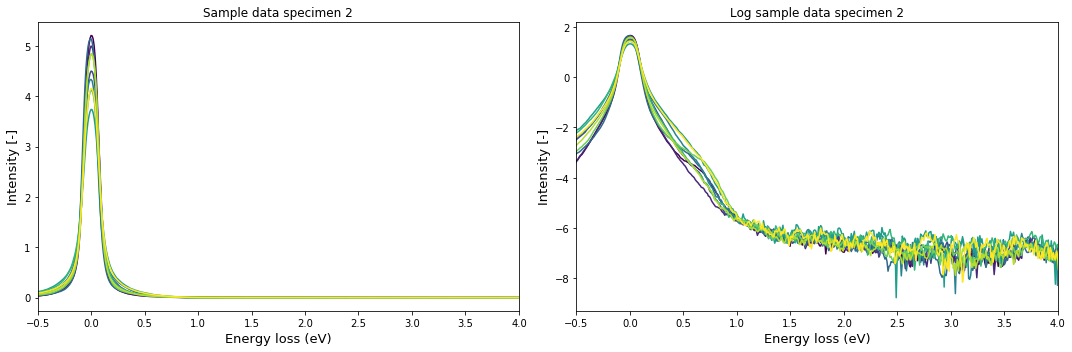

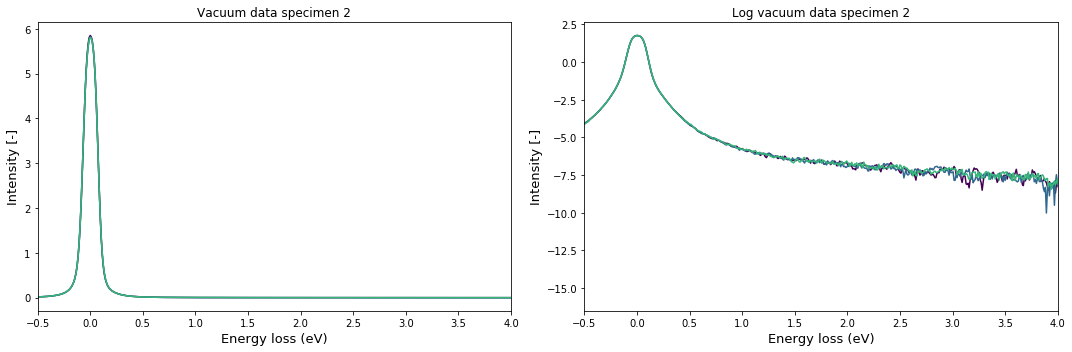

In [4]:
%run EELS-ZLP-July.py


## Create pd.DataFrames for vacuum and sample spectra

Column names: ['x', 'y', 'x_shifted', 'y_norm', 'log_y'] <br>

* x_shifted is the shifted spectrum s.t. $I_{max}$ is at $\Delta$E=0<br>
* y_norm is the normalized spectrum s.t. the total area under the curve = 1.

In [5]:
df_vacuum = pd.concat((file1, file2, file3))
df_vacuum = df_vacuum.sort_values('x').reset_index().drop('index', axis=1).dropna()

df = pd.concat((file4, file5, file6, file7, file8, file9, file10, file11, file12, file13))
df = df.sort_values('x').reset_index().drop('index', axis=1)

df['log_y'] = np.log(df['y'])

Use [x_shifted, y_norm] values of all the spectra as training inputs

In [6]:
x1, y1 = file1['x_shifted'], file1['y_norm']
x2, y2 = file2['x_shifted'], file2['y_norm']
x3, y3 = file3['x_shifted'], file3['y_norm']
x4, y4 = file4['x_shifted'], file4['y_norm']
x5, y5 = file5['x_shifted'], file5['y_norm']
x6, y6 = file6['x_shifted'], file6['y_norm']
x7, y7 = file7['x_shifted'], file7['y_norm']
x8, y8 = file8['x_shifted'], file8['y_norm']
x9, y9 = file9['x_shifted'], file9['y_norm']
x10, y10 = file10['x_shifted'], file10['y_norm']
x11, y11 = file11['x_shifted'], file11['y_norm']
x12, y12 = file12['x_shifted'], file12['y_norm']
x13, y13 = file13['x_shifted'], file13['y_norm']

In [7]:
%run Functions.ipynb

## Derivatives
In order to determine the values for $\Delta$E$_1$ and $\Delta$E$_2$, we calculate the derivatives of the intensity of each spectrum with respect to the change energy loss. We use the function 'smooth(y, window_len)' to smooth the functions and reveal underlying trends.

### In-sample

In [8]:
wl1 = 200
wl2 = 100

window_len = wl1
df_dx = pd.DataFrame({"x4": x4, "x5": x5, "x6": x6, "x7": x7, "x8": x8, "x9": x9,\
                      "x10":x10, "x11":x11, "x12":x12, "x13": x13, \
                      "y4": smooth(y4, window_len), "y5": smooth(y5, window_len), "y6": smooth(y6, window_len), \
                      "y7": smooth(y7, window_len), "y8": smooth(y8, window_len), "y9": smooth(y9, window_len), \
                      "y10": smooth(y10, window_len), "y11": smooth(y11, window_len), \
                      "y12": smooth(y12, window_len), "y13": smooth(y13, window_len)})
window_len = wl2

for i in range(4,14):
    df_dx['log y%(i)s' %{"i": i}] = np.log(df_dx['y%(i)s'% {"i": i}])
    df_dx['derivative y%(i)s' %{"i": i}] = np.divide(df_dx['y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['smooth derivative y%(i)s' %{"i": i}] = smooth(df_dx['derivative y%(i)s' %{"i": i}], window_len)
    df_dx['log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['log y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['smooth log derivative y%(i)s' %{"i": i}] = smooth(df_dx['log derivative y%(i)s' %{"i": i}], window_len)
    df_dx['2nd derivative y%(i)s' %{"i": i}] = np.divide(df_dx['smooth derivative y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())
    df_dx['2nd log derivative y%(i)s' %{"i": i}] = np.divide(df_dx['smooth log derivative y%(i)s'% {"i": i}].diff(), df_dx['x%(i)s'% {"i": i}].diff())   

Determine the first crossing with zero of the in-sample derivatives (dE$_{max}$):

In [9]:
li = []

for i in range(4,14):
    crossing = df_dx[(df_dx['log derivative y%(i)s' %{"i": i}] > 0) & (df_dx['x%(i)s'% {"i": i}] > 1)]['x%(i)s'% {"i": i}].min()
    li.append(crossing)
    
dE1 = min(li)
print("The value of dE1 is", dE1)
dE1_max = dE1

The value of dE1 is 2.97648


### In-vacuum

In [10]:
window_len = wl1
vac_dx = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, \
                      "y1": smooth(y1, window_len), "y2": smooth(y2, window_len), "y3": smooth(y3, window_len)})
window_len = wl2

for i in range(1,4):
    vac_dx['log y%(i)s' %{"i": i}] = np.log(vac_dx['y%(i)s'% {"i": i}])
    vac_dx['derivative y%(i)s' %{"i": i}] = np.divide(vac_dx['y%(i)s'% {"i": i}].diff(), vac_dx['x%(i)s'% {"i": i}].diff())
    vac_dx['smooth derivative y%(i)s' %{"i": i}] = smooth(vac_dx['derivative y%(i)s' %{"i": i}], window_len)
    vac_dx['log derivative y%(i)s' %{"i": i}] = np.divide(vac_dx['log y%(i)s'% {"i": i}].diff(), vac_dx['x%(i)s'% {"i": i}].diff())
    vac_dx['smooth log derivative y%(i)s' %{"i": i}] = smooth(vac_dx['log derivative y%(i)s' %{"i": i}], window_len)
    vac_dx['2nd derivative y%(i)s' %{"i": i}] = np.divide(vac_dx['smooth derivative y%(i)s'% {"i": i}].diff(), vac_dx['x%(i)s'% {"i": i}].diff())
    vac_dx['2nd log derivative y%(i)s' %{"i": i}] = np.divide(vac_dx['smooth log derivative y%(i)s'% {"i": i}].diff(), vac_dx['x%(i)s'% {"i": i}].diff())   

lo = []
for i in range(1,4):
    crossing = vac_dx[(vac_dx['log derivative y%(i)s' %{"i": i}] > 0) & (vac_dx['x%(i)s'% {"i": i}] > 1)]['x%(i)s'% {"i": i}].min()
    lo.append(crossing)


## Create plot of the derivatives

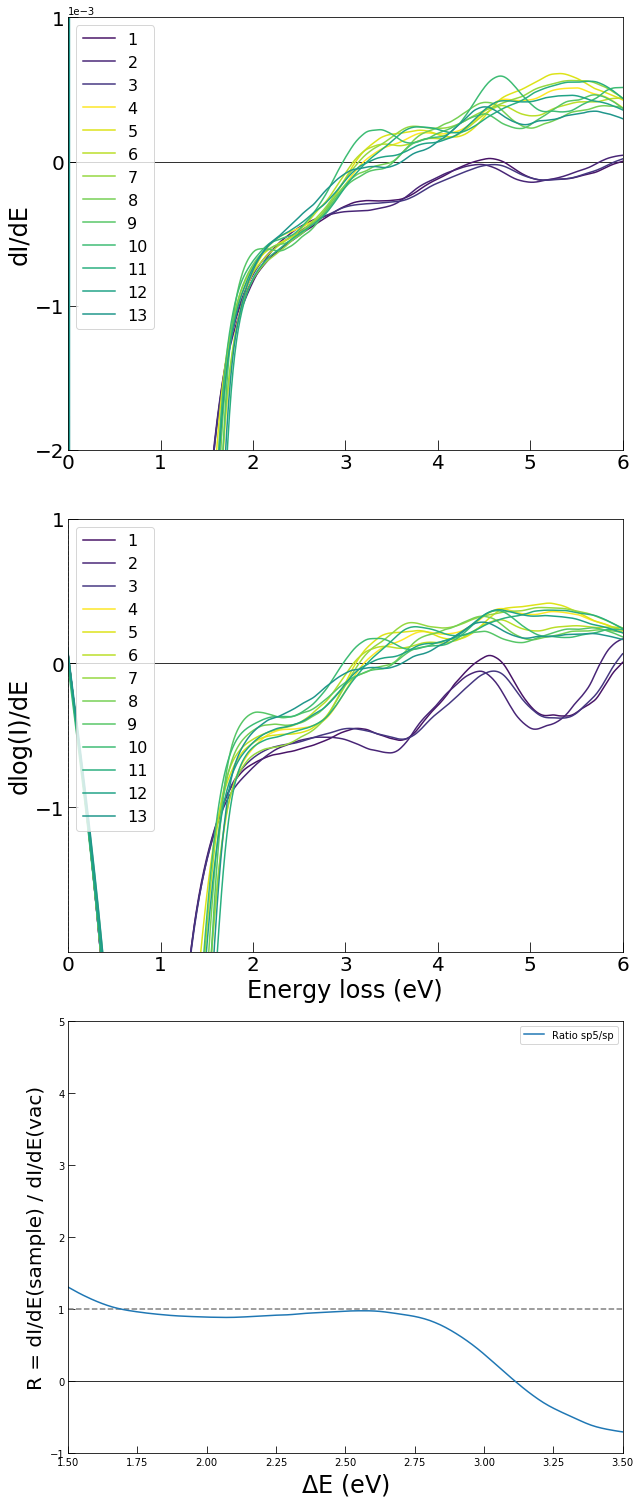

In [11]:
nrows, ncols = 3,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

cm_subsection = np.linspace(0,1,20) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})
          
for i in range(3):
    ax = plt.subplot(gs[i])
    ax.set_xlim([0,9])
    ax.tick_params(which='major',direction='in',length=7)
    ax.tick_params(which='minor',length=8)
    plt.axhline(y=0, color='black', linewidth=1, alpha=.8)
    plt.axvline(x=0, color='darkgray', linestyle='--', linewidth = 1)
    #plt.axvline(x=dE1, color='darkgray', linestyle='--', linewidth = 1, label='$\Delta$E1' %{'s': dE1})
    
    for j in range(1,4):
        if i == 0:
            p2 = ax.plot(vac_dx['x%(i)s'% {"i": j}],vac_dx['derivative y%(i)s' %{"i": j}], color=colors[j], label='%(i)s' %{"i": j})
            
        if i == 1: 
            p2 = ax.plot(vac_dx['x%(i)s'% {"i": j}],vac_dx['log derivative y%(i)s' %{"i": j}], color=colors[j], label='%(i)s' %{"i": j})     
    
    for j in range(4,14):
        k = j-3
        
        if i == 0:
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['derivative y%(i)s' %{"i": j}], color=colors[-k], label='%(i)s' %{"i": j})
            ax.set_ylim([-.002, .001])
            ax.set_xlim([0, 6])
            ax.set_ylabel('dI/dE',fontsize=24)
            ax.set_yticks([-0.002, -0.001, 0, 0.001])
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax.legend(loc=2, fontsize=16)
        if i == 1:
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['log derivative y%(i)s' %{"i": j}], color=colors[-k],label='%(i)s' %{"i": j})
            ax.set_ylim([-2, 1])
            ax.set_xlim([0, 6])
            ax.set_ylabel('dlog(I)/dE',fontsize=24)
            ax.set_yticks([-1, 0, 1])
            ax.legend(loc=2, fontsize=16)
        
    for j in ([5]):   
        if i == 2: 
            ax.axhline(y=1, linestyle='--', color='gray')
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}], np.divide(df_dx['derivative y%(i)s'% {"i": j}],vac_dx['derivative y1']), label='Ratio sp5/sp'%{"i":j})
            ax.set_ylim([-1, 5])
            ax.set_xlim([1.5,3.5])   
            ax.set_ylabel('R = dI/dE(sample) / dI/dE(vac)', fontsize=20)
            ax.set_xlabel('$\Delta$E (eV)', fontsize=24)
            ax.legend()
            
    
    if i == 0:
        ax.tick_params(labelbottom=True)
        ax.tick_params(which='major', length= 10, labelsize=20)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    if i == 1:
        ax.set_xlabel('Energy loss (eV)', fontsize=24)
        ax.tick_params(length= 10, labelsize=18)
        ax.tick_params(which='major', length= 10, labelsize=20)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    
plt.tight_layout()
plt.savefig("Derivatives.pdf")
plt.show()

## dE1 and dE2

The value of dE$_{max}$ was calculated as the first time the derivative dI/dE crosses zero.<br>
We train the neural network until a maximum energy loss, which we call dE1. 

In [12]:
dE1 = dE1_max - .4 - .15
dE2 = 5

print('The values of dE1 and dE2', dE1, dE2)

The values of dE1 and dE2 2.42648 5


## Window and prepare data
* Drop all data for $\Delta$E $> \Delta$E$_1$
* Calculate the binned mean and variance of the spectra together with the function 'binned_statistics(x,y,nbins)'
* Returns two pd.DataFrames 'df_mean' and 'df_vacmean' with the mean and variance data of the in-sample and in-vacuum spectra



In [13]:
df_window = df[(df['x_shifted'] < dE1) & (df['x_shifted'] > -.5)]
df_window_vacuum = df_vacuum[(df_vacuum['x_shifted'] <= dE1) & (df_vacuum['x_shifted'] > -.5)]

df_mean, df_vacmean = pd.DataFrame(), pd.DataFrame()
nbins = 50

df_mean['x'] = np.linspace(df_window['x_shifted'].min(),df_window['x_shifted'].max(), nbins)
df_mean['y'], df_mean['sigma'] = binned_statistics(df_window['x_shifted'], np.log(df_window['y']), nbins)[0:2]

df_vacmean['x'] = np.linspace(df_window_vacuum['x_shifted'].min(),df_window_vacuum['x_shifted'].max(), nbins)
df_vacmean['y'], df_vacmean['sigma'] = binned_statistics(df_window_vacuum['x_shifted'], np.log(df_window_vacuum['y']), nbins)[0:2]



### Create pseudo data for $\Delta$E $ > \Delta$E$_2$

In [14]:
min_x = dE2
max_x = 12
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': .5 * np.ones(N_pseudo), \
                    'sigma': .2 * np.ones(N_pseudo)})

df_full = pd.concat([df_mean, df_pseudo])

### Create architecture

In [15]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [16]:
tf.reset_default_graph()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value
df_train, df_test = train_test_split(df_train_full, test_size=0.18, random_state=26)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = (np.copy(df_train['y'])).reshape(N_train,1)
train_sigma = (np.copy(df_train['sigma'])).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = (np.copy(df_test['y'])).reshape(N_test,1)
test_sigma = (np.copy(df_test['sigma'])).reshape(N_test,1)

predictions = make_model(x,1)
N_pred = 30000
predict_x = np.linspace(-.3,12,N_pred).reshape(N_pred,1)

#train_scaler = StandardScaler()
#train_scaler.fit(train_x)
#test_scaler = StandardScaler()
#test_scaler.fit(test_x)
train_sigma.shape

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


(65, 1)

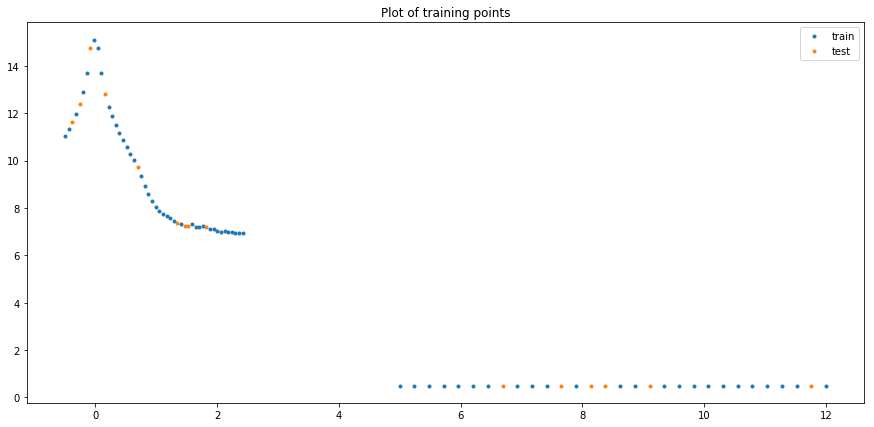

In [17]:
plt.figure(figsize=(15,7))
#plt.xlim([-0.35, -0.2])
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.title('Plot of training points')
plt.legend()

## Create MC replicas

In [18]:
Nrep = 5000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

In [21]:
import time
from datetime import datetime
now = datetime.now()


def function_train(it):
    
    chi_array = []
    
    processor = 'processor' + str(it)
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
    eta = 2e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta)
    saver = tf.train.Saver(max_to_keep=40)
    print("%(p)s starts training on" %{'p': processor}, '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")
    
    Nrep = 160

    for i in range(Nrep):

        train_y = train_y_reps[:, i*4 + it].reshape(N_train,1)
        test_y = test_y_reps[:, i*4 + it].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 100
        prev_epoch=0
        avg_cost = 0.0

        array_train = []
        array_test = []

        with tf.Session() as sess:
            
            
            
            sess.run(tf.global_variables_initializer())
            
            training_epochs = 20000
            max_rising_epochs = 50000 #The amount of epochs the minimzer is allowed to overfit before it stops
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/%(processor)s/my-model.ckpt' %{'processor': processor} , global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/%(processor)s/my-model.ckpt-%(s)s' % {'processor': processor, 's': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            


            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = now.strftime("%d.%m.%Y")
            t_string = now.strftime("%H:%M:%S")
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_model/%(s)s_x1_processor%(it)s_%(i)s' % {'s': d_string, 'it': it, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        np.savetxt('Data/Results/Part2/%(date)s/x1_xyp1p2_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i+10 }, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt('Data/Results/Part2/%(date)s/x1_chi_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt('Data/Results/Part2/%(date)s/x1_extrapolation_e%(epoch)s_%(i)s.csv' % {"date": d_string, "epoch": processor, "i": i +10}, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Parallel training

In [22]:
# make sure to always use multiprocess
from multiprocess import Pool
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

number_of_cores=4
# start your parallel workers at the beginning of your script
pool = Pool(number_of_cores)

# execute a computation(s) in parallel
result1 = pool.map(function_train, [1,2,3,4])

pool.close()

#print(pool)


processor3 starts training on 0065 and validating on 0015 samples
processor4 starts training on 0065 and validating on 0015 samples
processor2 starts training on 0065 and validating on 0015 samples
processor1 starts training on 0065 and validating on 0015 samples
Epoch: 0001 | Training cost= 1000.059997559 | Validation cost= 1209.771850586
Epoch: 0001 | Training cost= 1008.106506348 | Validation cost= 1205.156127930
Epoch: 0001 | Training cost= 1007.000122070 | Validation cost= 1235.551879883
Epoch: 0001 | Training cost= 1004.434326172 | Validation cost= 1199.462768555
Epoch: 1001 | Training cost= 11.871733665 | Validation cost= 13.644439697
Epoch: 1001 | Training cost= 11.974661827 | Validation cost= 11.849916458
Epoch: 1001 | Training cost= 12.739909172 | Validation cost= 10.586456299
Epoch: 1001 | Training cost= 14.485393524 | Validation cost= 8.973604202
Epoch: 2001 | Training cost= 6.160062790 | Validation cost= 10.356005669
Epoch: 2001 | Training cost= 7.029579639 | Validation co

Epoch: 0001 | Training cost= 1008.985717773 | Validation cost= 1225.539306641
Epoch: 1001 | Training cost= 11.743709564 | Validation cost= 8.952534676
Epoch: 1001 | Training cost= 12.059315681 | Validation cost= 7.068952560
Epoch: 1001 | Training cost= 12.886328697 | Validation cost= 6.414069653
Epoch: 1001 | Training cost= 12.678400040 | Validation cost= 8.011735916
Epoch: 2001 | Training cost= 7.111046791 | Validation cost= 5.681909561
Epoch: 2001 | Training cost= 7.270032406 | Validation cost= 4.150246620
Epoch: 2001 | Training cost= 6.588299751 | Validation cost= 3.623370886
Epoch: 2001 | Training cost= 7.304094315 | Validation cost= 3.486940622
Epoch: 3001 | Training cost= 2.462094784 | Validation cost= 1.589142084
Epoch: 3001 | Training cost= 1.967003703 | Validation cost= 1.681390405
Epoch: 3001 | Training cost= 2.233013868 | Validation cost= 2.844230652
Epoch: 3001 | Training cost= 2.332882643 | Validation cost= 1.541452646
Epoch: 4001 | Training cost= 1.718000889 | Validation 

Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
Traceback (most recent call last):
  File "/Users/laurienroest/opt/anaconda3/lib/python3.7/site-package

KeyboardInterrupt: 